# Install Dependencies

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16927, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 16927 (delta 62), reused 87 (delta 48), pack-reused 16805 (from 1)
Receiving objects: 100% (16927/16927), 15.68 MiB | 3.05 MiB/s, done.
Resolving deltas: 100% (11591/11591), done.
/home/ubuntu/otus_cv/hw_final/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=10018MB, multi_processor_count=68)


# Download a Dataset

Add your Roboflow API key below to download the default money counting dataset. Alternatively, use the code provided by the Roboflow dashboard in the above step to load a custom dataset.

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="G17cDggpZioiUyOSqOsJ")
project = rf.workspace("paul-nlfem").project("od_ai")
version = project.version(14)
dataset = version.download("yolov5")

     |████████████████████████████████| 79 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 49.9 MB 6.5 kB/s eta 0:00:01     |█████████████▎                  | 20.7 MB 4.3 MB/s eta 0:00:07
     |████████████████████████████████| 66 kB 162 kB/s eta 0:00:01
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to OD_AI-14 in yolov5pytorch:: 100%|██████████| 4598/4598 [00:00<00:00, 9068.72it/s]


In [20]:
YOLO5_PATH = %pwd
# print(YOLO5_PATH)
# PWD = %pwd + dataset.location
# %cd ..


/home/ubuntu/otus_cv/hw_final/yolov5


In [22]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- harvester
- person
- post
- tractor
nc: 4
roboflow:
  license: CC BY 4.0
  project: od_ai
  url: https://universe.roboflow.com/paul-nlfem/od_ai/dataset/14
  version: 14
  workspace: paul-nlfem
test: ../test/images
train: OD_AI-14/train/images
val: OD_AI-14/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [23]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [24]:
#this is the model configuration we will use for our tutorial
%cat $YOLO5_PATH/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [25]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [26]:
%%writetemplate $YOLO5_PATH/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [30]:
# train yolov5s on custom data for 100 epochs
# time its performance
# %%time
%cd $YOLO5_PATH
!python3 train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/home/ubuntu/otus_cv/hw_final/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/home/ubuntu/otus_cv/hw_final/yolov5/OD_AI-14/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 290 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3080, 10018MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.00

                Class     Images  Instances          P          R      mAP50   
                   all        144        433      0.804      0.758      0.766      0.469
             harvester        144         38       0.96      0.974      0.977      0.643
                person        144         64      0.788      0.766      0.804      0.527
                  post        144        280      0.566       0.35       0.34      0.128
               tractor        144         51      0.902      0.941      0.942      0.579

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

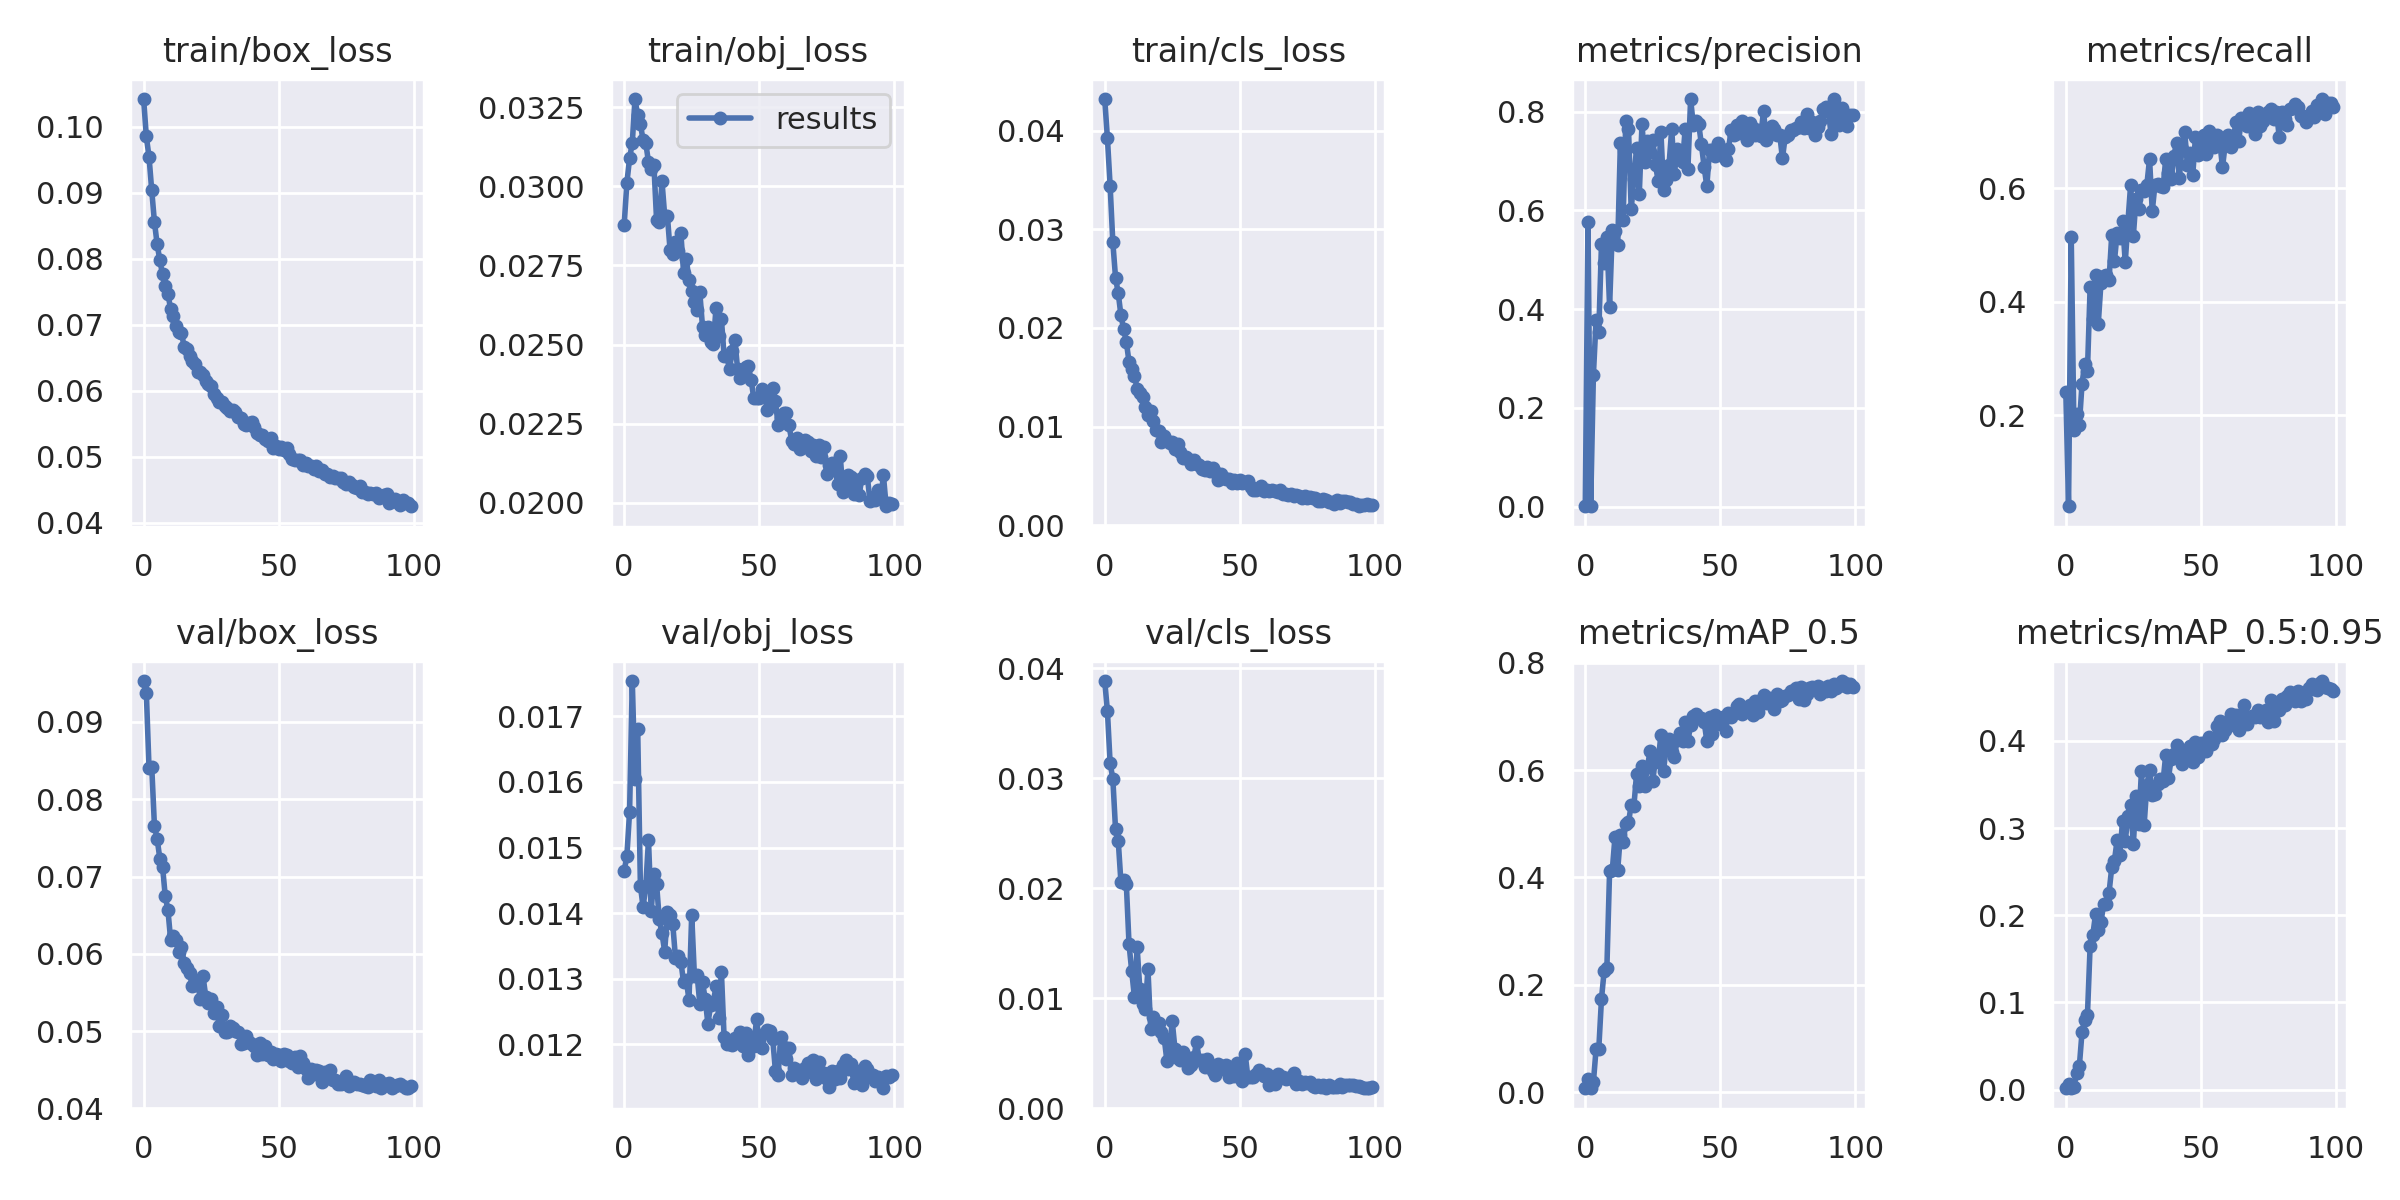

In [31]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename=f'{YOLO5_PATH}/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [33]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [34]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


## Photos from dataset

In the snippet below, replace `OD_AI-14` with the name of the folder in which your dataset is stored.

In [35]:
# %cd /content/yolov5/
!python3 detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source OD_AI-14/test/images/

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=OD_AI-14/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3080, 10018MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
image 1/142 /home/ubuntu/otus_cv/hw_final/yolov5/OD_AI-14/test/images/12742849_163405017374570_6774044920778989438_n_jpg.rf.be138abb6ecf6fbbcedab3ab970da0d9.jpg: 416x416 (no detections), 8.1ms
image 2/142 /home/ubuntu/otus_cv/hw_final/yolov5/OD_AI-14/test/images/168153-17032596_jpg.rf.d72acae297124b8169c5a717a0f6d646.jpg

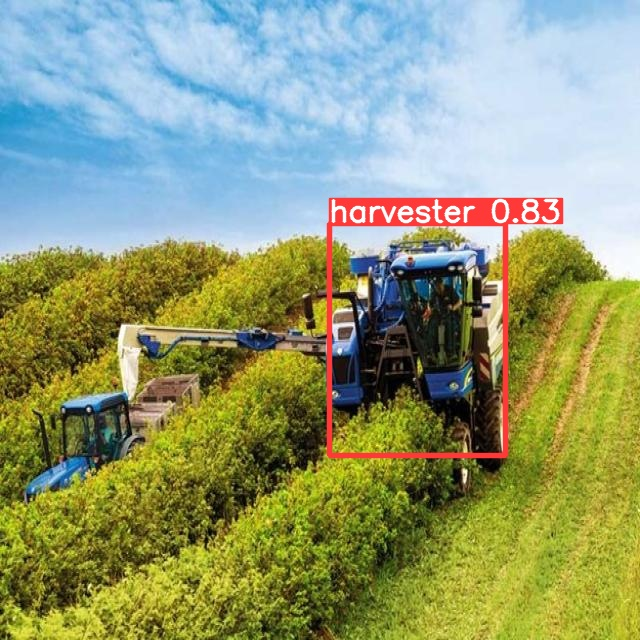

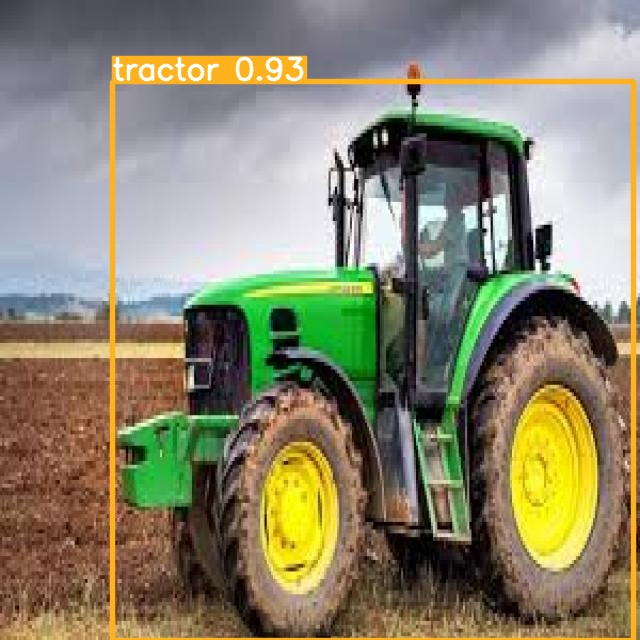

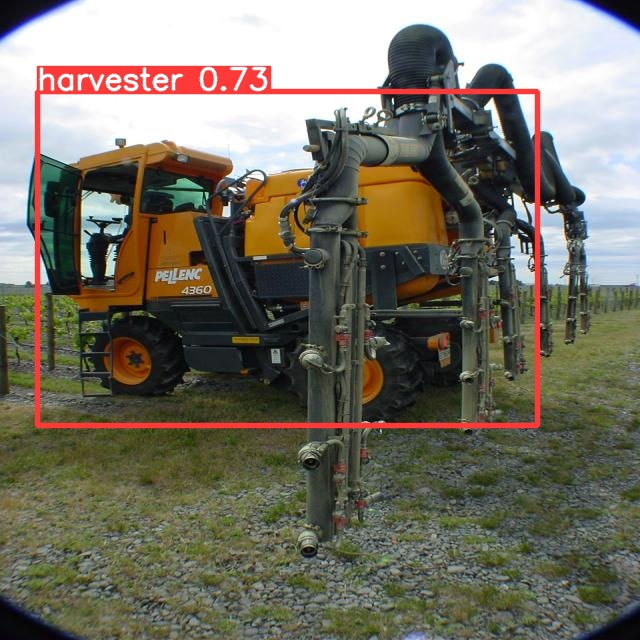

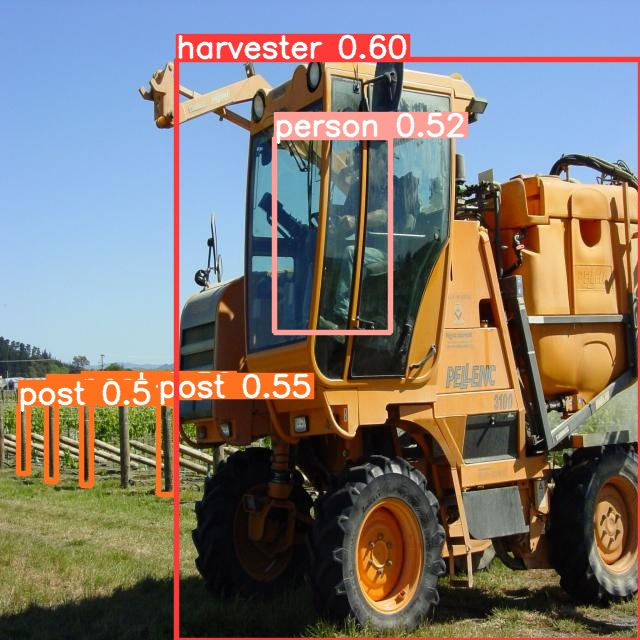

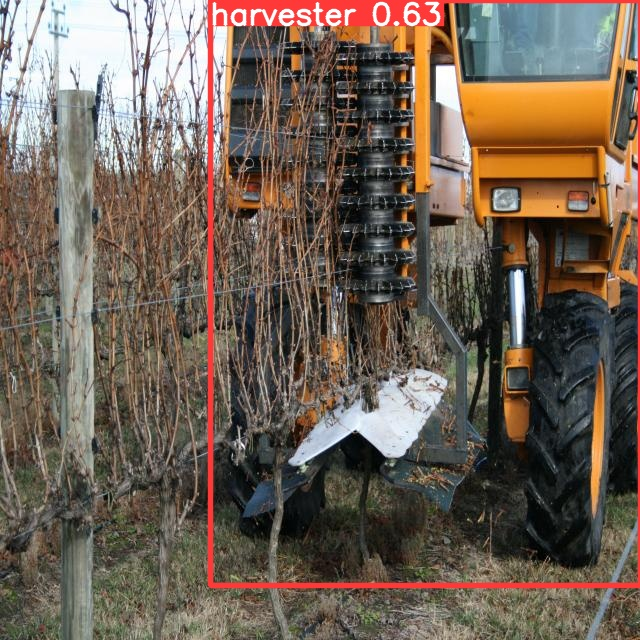

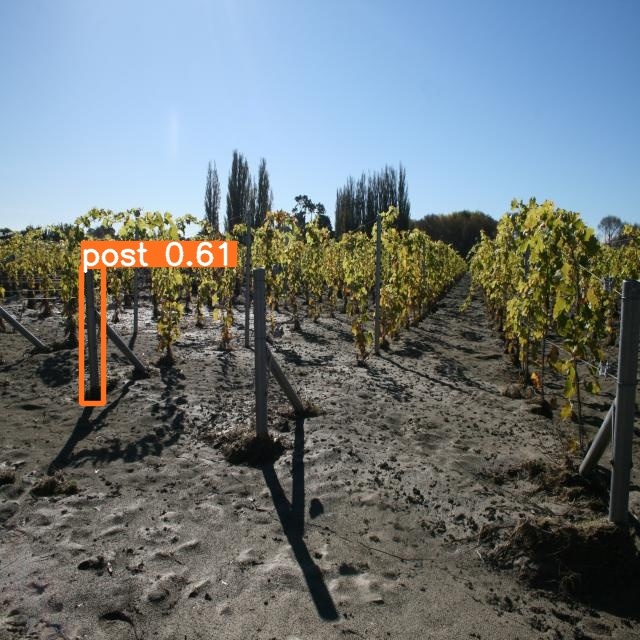

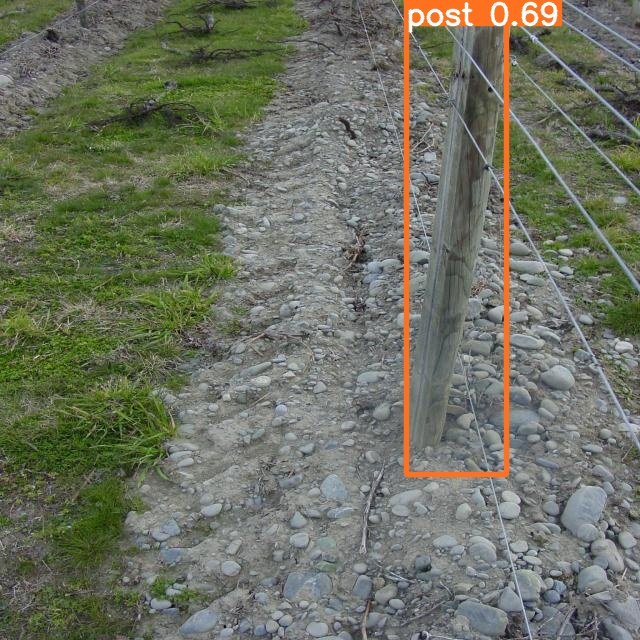

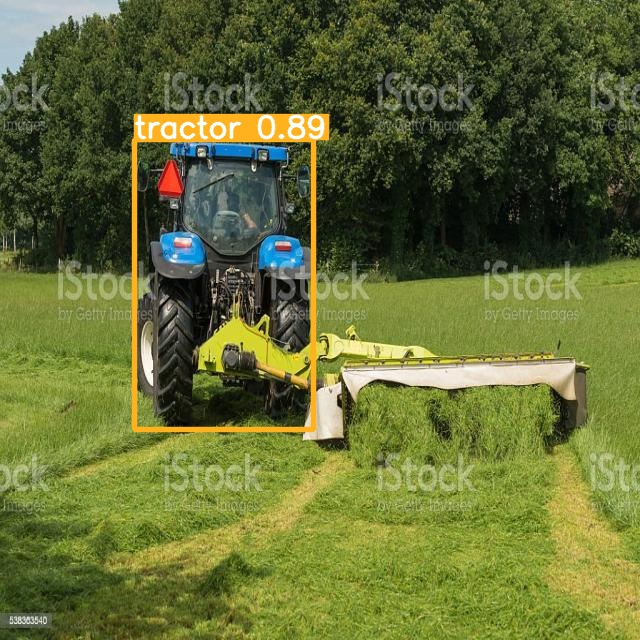

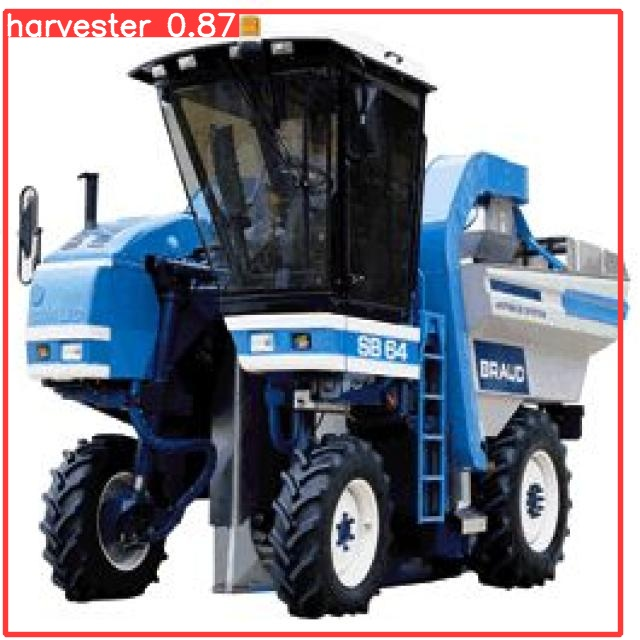

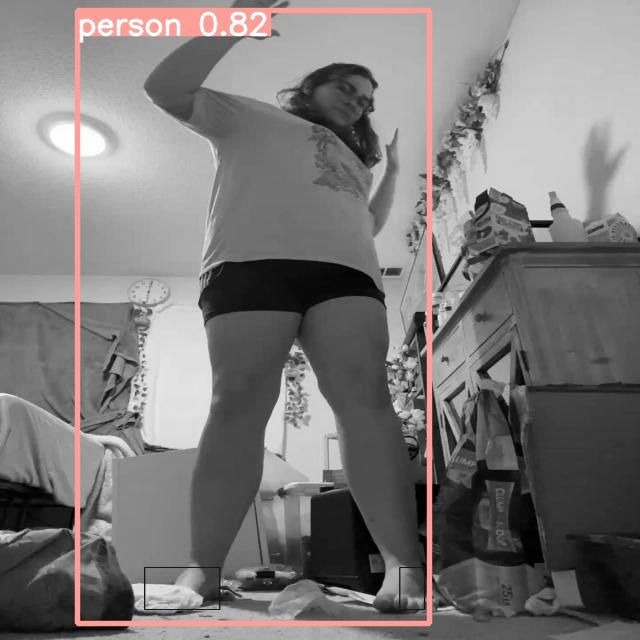

In [37]:
import glob
from IPython.display import Image, display

for imageName in glob.glob(f'{YOLO5_PATH}/runs/detect/exp/*.jpg')[10:20]: #assuming JPG
    display(Image(filename=imageName))

## Custom YouTube video #1

Последовательность действий:

1. Записать видео с экрана, например при помощи OBS Studio
2. Уменьшить разрешение и преобразовать фортмат при помощи ffmpeg  
```bash
ffmpeg -i "2024-08-29 13-17-10.mkv" -vf scale=640:360 tracktor_competition_360p.mp4
```
3. Скопировать на сервер
4. Запустить инференс YOLO
5. Скопировать назад, запустив на ПК команду scp, например:  
```bash
scp -i "C:\Users\edkol\.ssh\teslat4-pytorch-190004-evgenyko.pem" ubuntu@81.94.159.39:/home/ubuntu/otus_cv/hw_final/yolov5/run
s/detect/exp3/tracktor_competition_360p.mp4 .
```

In [39]:
%ls ..

harvesters_tracktors.mp4  train_yolov5_object_detection_on_custom_data.ipynb
project_plan.md           yolov5/


In [41]:
!python3 detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../tracktor_competition_360p.mp4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../tracktor_competition_360p.mp4, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3080, 10018MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
video 1/1 (1/1950) /home/ubuntu/otus_cv/hw_final/tracktor_competition_360p.mp4: 256x416 1 post, 3 tractors, 13.5ms
video 1/1 (2/1950) /home/ubuntu/otus_cv/hw_final/tracktor_competition_360p.mp4: 256x416 1 post, 3 tractors, 8.5ms
video 1/1 (3/1950) /home/ubuntu/otus_cv/hw_final/tracktor_competition_360p.mp4: 25